In [56]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [57]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [58]:
!ls $zip_path
!mv $zip_path/* .
!ls .

jena_climate_2009_2016.csv
jena_climate_2009_2016.csv  sample_data


## Data inspection

In [59]:
df = pd.read_csv('jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

In [60]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


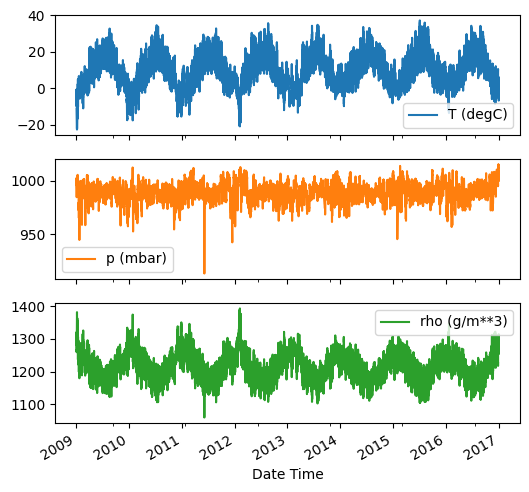

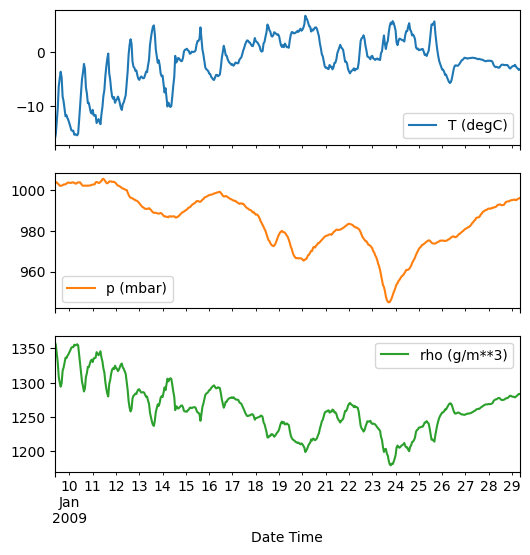

In [61]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(6,6))

plot_features = df[plot_cols][200:680]
plot_features.index = date_time[200:680]
_ = plot_features.plot(subplots=True, figsize=(6,6))

In [62]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


## Data Clean-up

In [63]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

## Feature engineering

Wind: polar to Cartesian coordinates

In [64]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(np.float64(-11.305513973134667),
 np.float64(8.24469928549079),
 np.float64(-8.27438540335515),
 np.float64(7.7338312955467785))

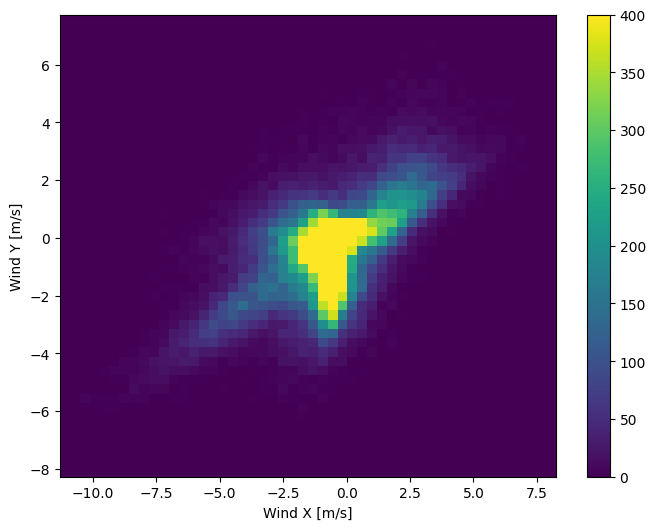

In [65]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Time : periodicity

In [66]:
# Create a Timestamp object
ts = pd.Timestamp('2024-06-24 10:30:00')

# Get the POSIX timestamp
posix_timestamp = ts.timestamp()

print(f"The Timestamp object: {ts}")
print(f"The POSIX timestamp: {posix_timestamp}")

The Timestamp object: 2024-06-24 10:30:00
The POSIX timestamp: 1719225000.0


Text(0.5, 1.0, 'Time of year signal')

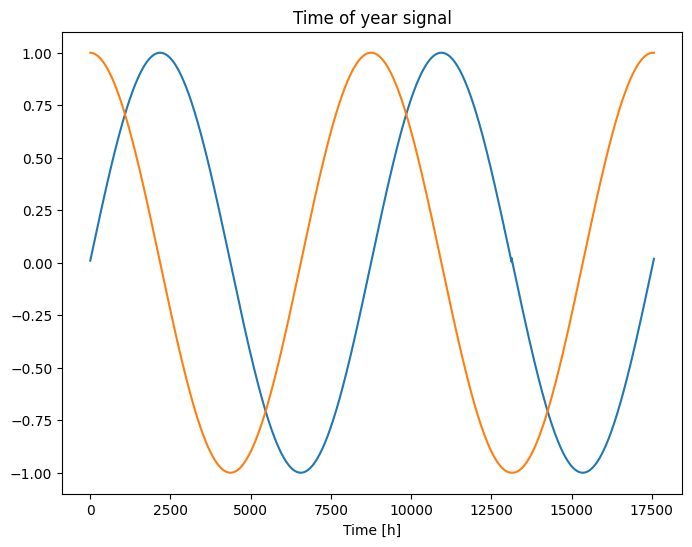

In [67]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Year sin'])[:2*24*366])
plt.plot(np.array(df['Year cos'])[:2*24*366])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

## Data split and normalization

In [68]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

/tmp/ipython-input-69-1083677214.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


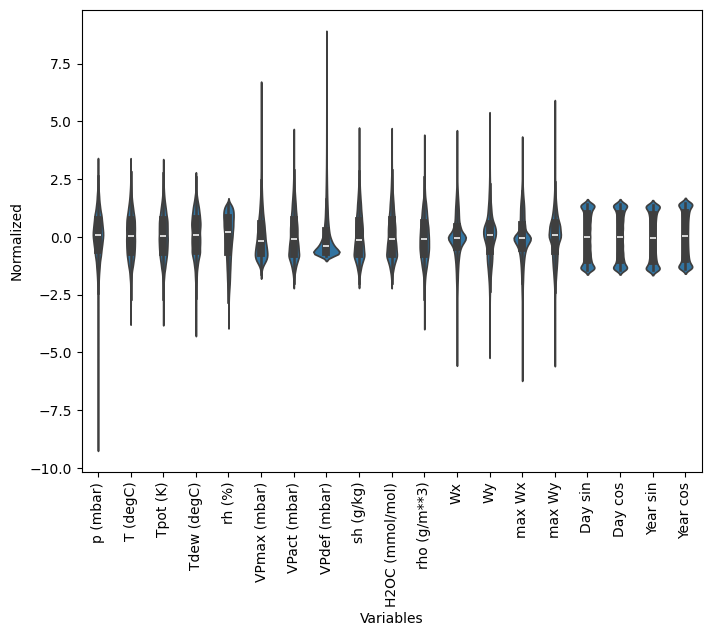

In [69]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Variables', value_name='Normalized')

plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='Variables', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## **Time-series forecasting**



### Data time-windowing, time-window plotting, and batch preparation

In [70]:
class data_windowing():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch = None
    self.inputs = None
    self.labels = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def slice_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    self.inputs = inputs
    self.labels = labels

    return self.inputs, self.labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    #inputs, labels = self.get_batch
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(self.inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, self.inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, self.labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(self.inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.slice_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def get_batch(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self.batch = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [71]:
# Example: stack three slices, the length of the total window.
w = data_windowing(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
windows = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

w.inputs, w.labels = w.slice_window(windows)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {windows.shape}')
print(f'Inputs shape: {w.inputs.shape}')
print(f'Labels shape: {w.labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


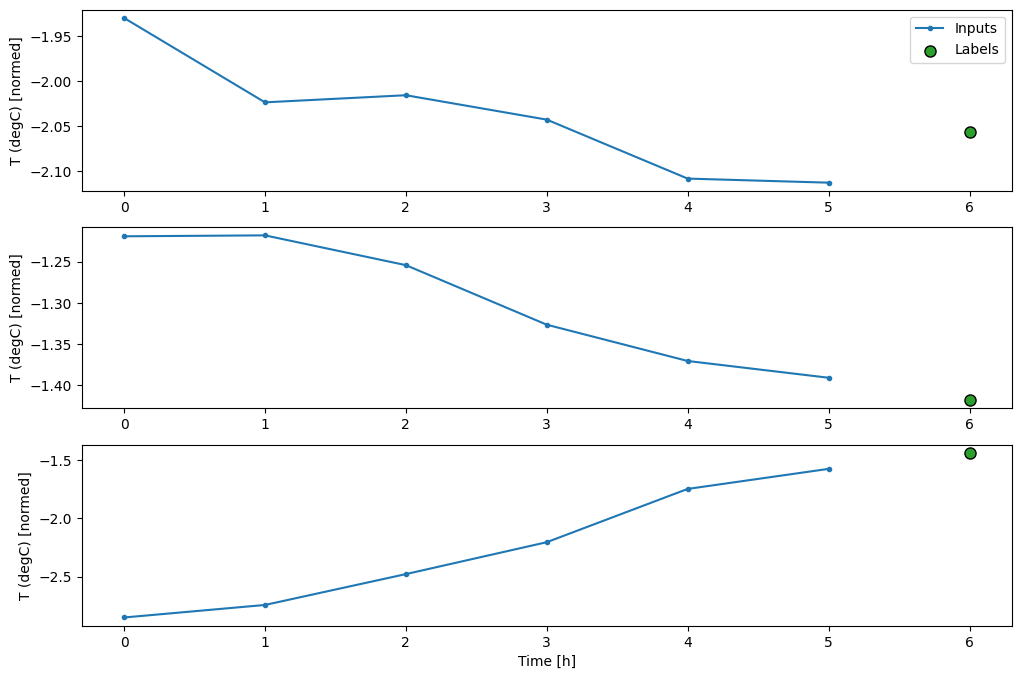

In [72]:
# Plot (input & predection) time window
w.plot()

In [73]:
# Take a look at the shape of each batch, input and label
w.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [74]:
# Now prepare full 32 batches of train data
for batch_inputs, batch_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {batch_inputs.shape}')
  print(f'Labels shape (batch, time, features): {batch_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Forecasting Models
Single-step predictions
 - Baseline: single-step forward
 - Single-step input: Linear and DNN
 - Multi-step input: DNN, CNN, and RNN:LSTM

Multi-step predictions
 - Single-shot:
   * Single-step input linear and DNN,
   * Multi-step input CNN, RNN:LSTM
 - Autoregressive
   * feedback RNN:LSTM

In [75]:
class Single_step_forward(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [76]:
# Linear - Single-step input single-step prediction
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [77]:
# DNN - Single-step input single-step prediction
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [78]:
# DNN - Multi-step input single-step prediction
multi_input_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [79]:
# Convolutional Neural Networks (CNN)- multi-step input, single-step prediction
CONV_WIDTH = 3
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [80]:
# Recurrent neural network (RNN) : Long-Short Term Memory (LSTM)
# - multi-step input, single-step prediction

lstm = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [81]:
# Single-shot: Linear - single-step input multi-step prediction
OUT_STEPS = 24
multi_linear = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [82]:
# Single-shot: DNN - single-step input multi-step prediction
multi_output_dense = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [83]:
# Single-shot: CNN - multi-step input multi-step prediction

multi_cnn = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [84]:
# Single-shot: RNN:LSTM - multi-step input multi-step prediction
multi_lstm = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [85]:
# Autoregressive RNN:LSTM
class autoregressive_rnn(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                              training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

In [86]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### Time windows
Single-step predictions
 - Single step input window
 - Wide input window (24)
 - Convolution kernel input (3)
 - Wide input window for CNN (24)

Multi-step predictions
 - Wide input & multi-output window (24+24)


In [87]:
# Single step input window
single = data_windowing(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [88]:
# Wide input window (24 steps)
wide = data_windowing(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

for wide_inputs, wide_labels in wide.train.take(1):
  print(f'Inputs shape (batch, time, features): {wide_inputs.shape}')
  print(f'Labels shape (batch, time, features): {wide_labels.shape} \n')
  wide.inputs = wide_inputs
  wide.labels = wide_labels

wide

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 1) 



Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [89]:
# Convolution kernel input
conv = data_windowing(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

for conv_inputs, conv_labels in conv.train.take(1):
  print(f'Inputs shape (batch, time, features): {conv_inputs.shape}')
  print(f'Labels shape (batch, time, features): {conv_labels.shape} \n')
  conv.inputs = conv_inputs
  conv.labels = conv_labels

conv

Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1) 



Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [90]:
# Wide input window for CNN
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv = data_windowing(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

for conv_inputs, conv_labels in wide_conv.train.take(1):
  print(f'Inputs shape (batch, time, features): {conv_inputs.shape}')
  print(f'Labels shape (batch, time, features): {conv_labels.shape} \n')
  wide_conv.inputs = conv_inputs
  wide_conv.labels = conv_labels

wide_conv

Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1) 



Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [91]:
# Wide input & multi output
multi_out = data_windowing(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

for multiout_inputs, multiout_labels in multi_out.train.take(1):
  print(f'Inputs shape (batch, time, features): {multiout_inputs.shape}')
  print(f'Labels shape (batch, time, features): {multiout_labels.shape} \n')
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels

multi_out

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19) 



Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

### Results

Single-step prediction models

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0784


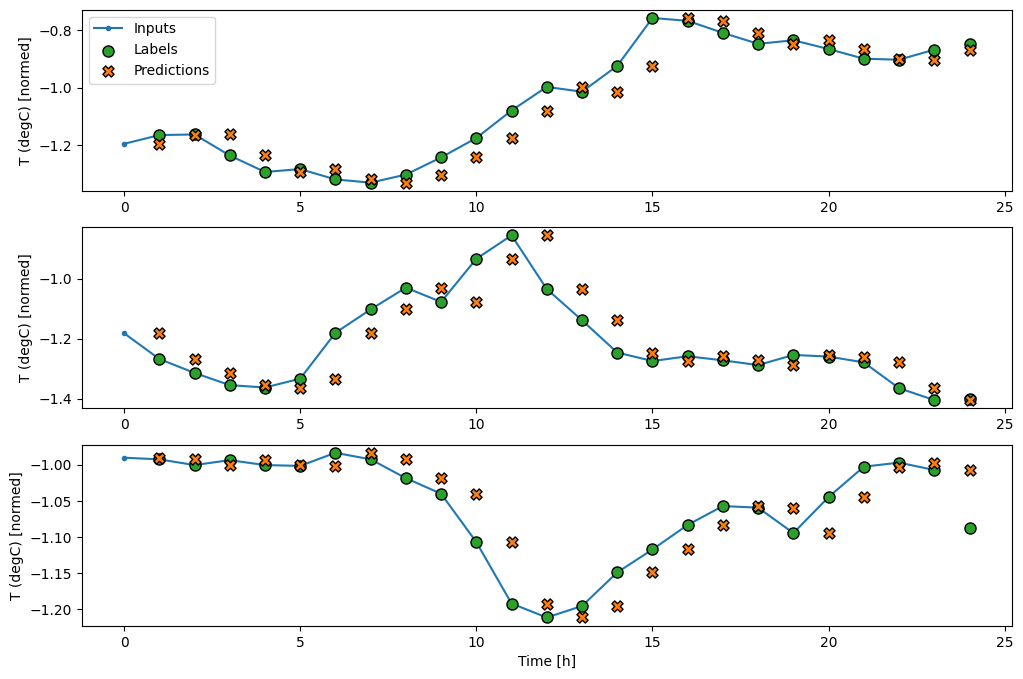

In [92]:
# Single step forward
ssf = Single_step_forward(label_index=column_indices['T (degC)'])

ssf.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = ssf.evaluate(single.val, return_dict=True)
performance['Baseline'] = ssf.evaluate(single.test, verbose=0, return_dict=True)

wide.plot(ssf)

Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3424 - mean_absolute_error: 0.4217 - val_loss: 0.0140 - val_mean_absolute_error: 0.0892
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0824 - val_loss: 0.0095 - val_mean_absolute_error: 0.0730
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0718 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0692
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0690 - val_loss: 0.0086 - val_mean_absolute_error: 0.0689
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0089 - mean_absolute_error: 0.0684 - val_loss: 0.0086 - val_mean_absolute_error: 0.0686
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0088 - mean_absolu

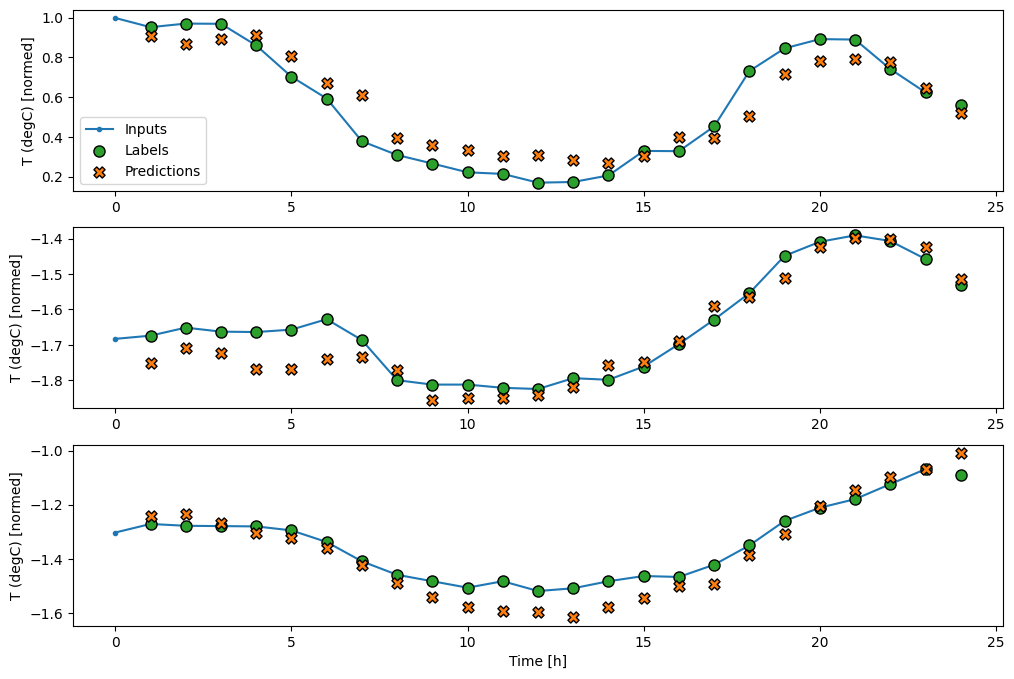

In [93]:
# Single-step input linear

history = compile_and_fit(linear, single)

val_performance['Linear'] = linear.evaluate(single.val, return_dict=True)
performance['Linear'] = linear.evaluate(single.test, verbose=0, return_dict=True)

for wide_inputs, wide_labels in wide.train.take(1):
  wide.inputs = wide_inputs
  wide.labels = wide_labels
wide.plot(linear)

Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0493 - mean_absolute_error: 0.1153 - val_loss: 0.0082 - val_mean_absolute_error: 0.0665
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0079 - mean_absolute_error: 0.0646 - val_loss: 0.0071 - val_mean_absolute_error: 0.0612
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0073 - mean_absolute_error: 0.0617 - val_loss: 0.0077 - val_mean_absolute_error: 0.0646
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0072 - mean_absolute_error: 0.0611 - val_loss: 0.0072 - val_mean_absolute_error: 0.0599
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0605


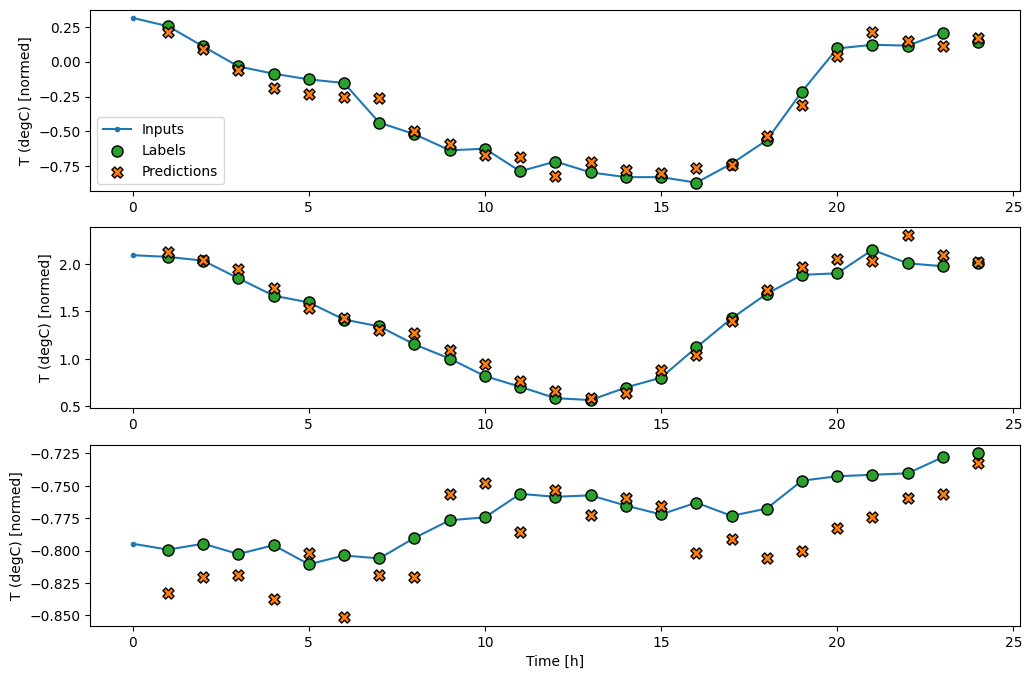

In [94]:
# Single-step input DNN
history = compile_and_fit(dense, single)

val_performance['Dense'] = dense.evaluate(single.val, return_dict=True)
performance['Dense'] = dense.evaluate(single.test, verbose=0, return_dict=True)

for wide_inputs, wide_labels in wide.train.take(1):
  wide.inputs = wide_inputs
  wide.labels = wide_labels
wide.plot(dense)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0569


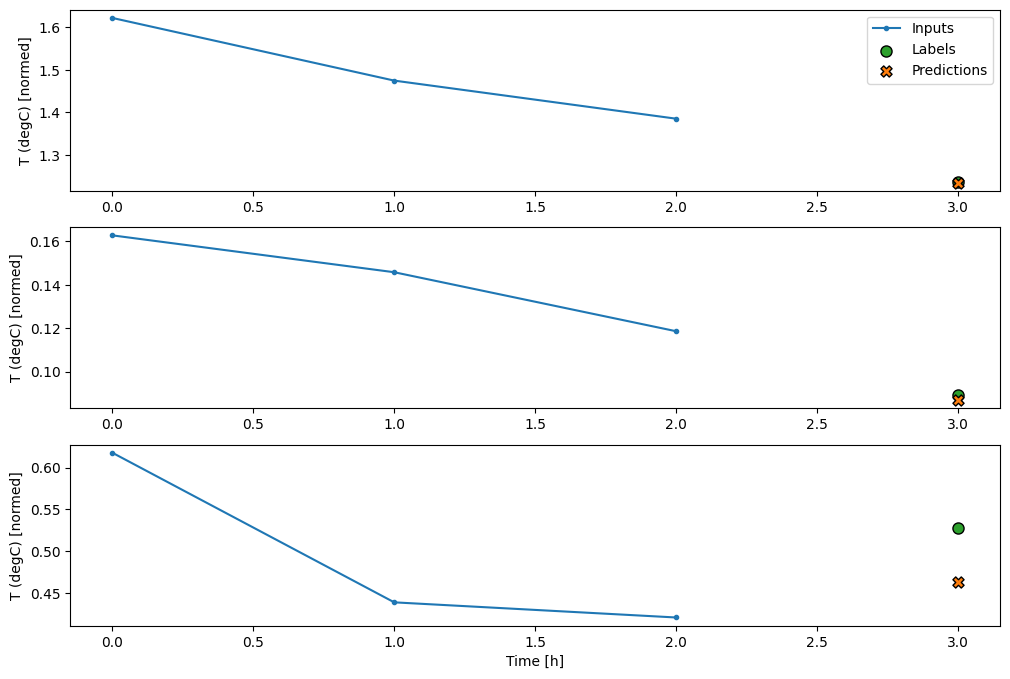

In [95]:
# Multi-step input DNN
history = compile_and_fit(multi_input_dense, conv)

IPython.display.clear_output()
val_performance['Multi-step DNN'] = multi_input_dense.evaluate(conv.val, return_dict=True)
performance['Multi-step DNN'] = multi_input_dense.evaluate(conv.test, verbose=0, return_dict=True)

for conv_inputs, conv_labels in conv.train.take(1):
  conv.inputs = conv_inputs
  conv.labels = conv_labels
conv.plot(multi_input_dense)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0617


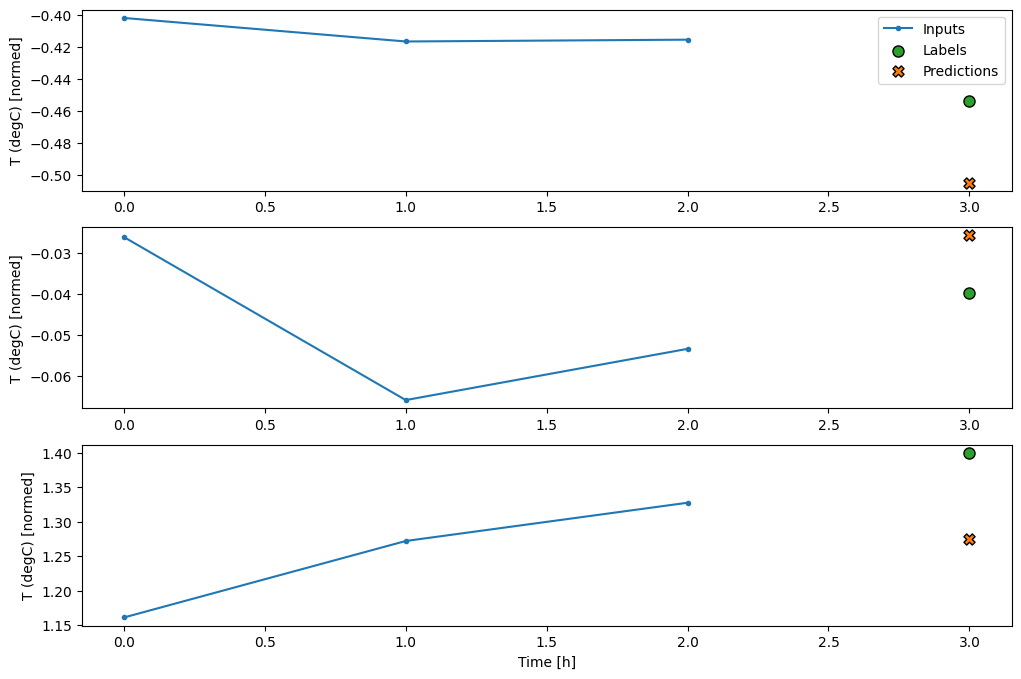

In [96]:
# CNN
history = compile_and_fit(cnn, conv)

IPython.display.clear_output()
val_performance['CNN'] = cnn.evaluate(conv.val, return_dict=True)
performance['CNN'] = cnn.evaluate(conv.test, verbose=0, return_dict=True)

for conv_inputs, conv_labels in conv.train.take(1):
  conv.inputs = conv_inputs
  conv.labels = conv_labels
conv.plot(cnn)

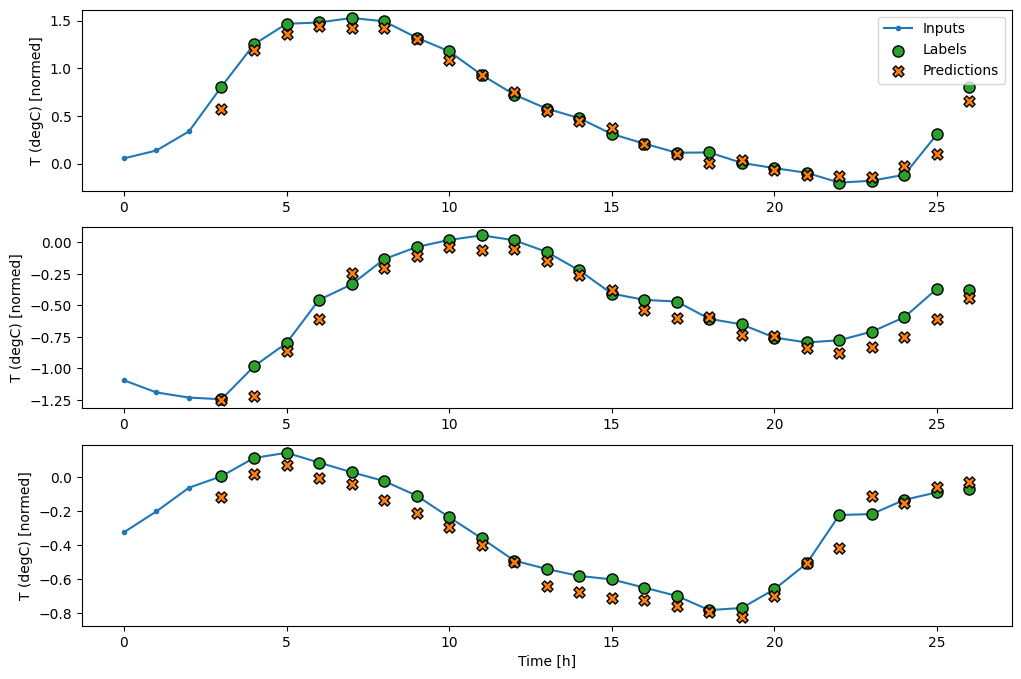

In [97]:
# Wide input window CNN
wide_conv.plot(cnn)

438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0506


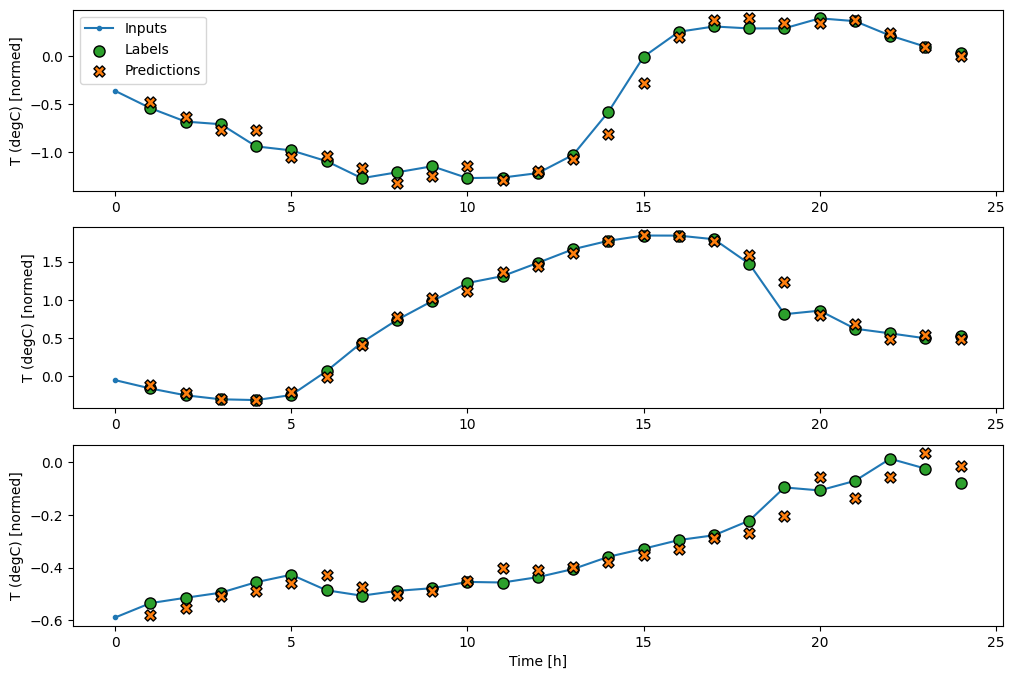

In [98]:
# LSTM
history = compile_and_fit(lstm, wide)

IPython.display.clear_output()
val_performance['LSTM'] = lstm.evaluate(wide.val, return_dict=True)
performance['LSTM'] = lstm.evaluate(wide.test, verbose=0, return_dict=True)

for wide_inputs, wide_labels in wide.train.take(1):
  wide.inputs = wide_inputs
  wide.labels = wide_labels

wide.plot(lstm)

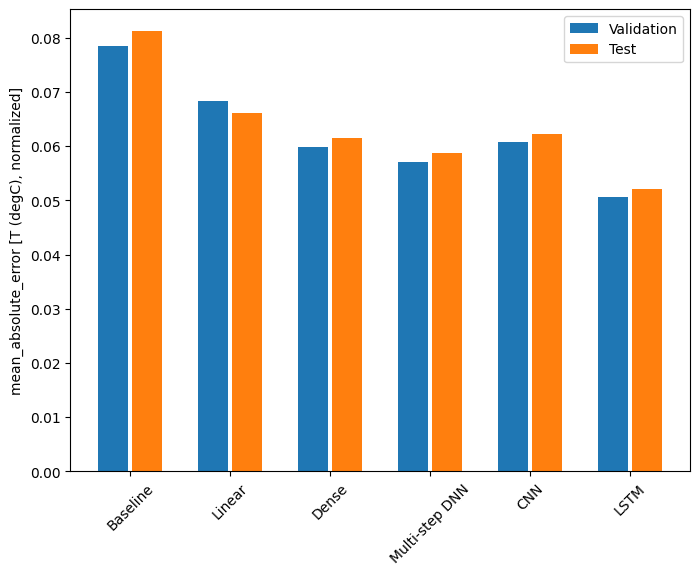

In [99]:
# Performance comparison for Single-step predictions
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [100]:
cm = lstm.metrics[1]
cm.metrics

for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0812
Linear      : 0.0661
Dense       : 0.0616
Multi-step DNN: 0.0587
CNN         : 0.0623
LSTM        : 0.0521



Multi-step prediction models

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2459 - mean_absolute_error: 0.2994


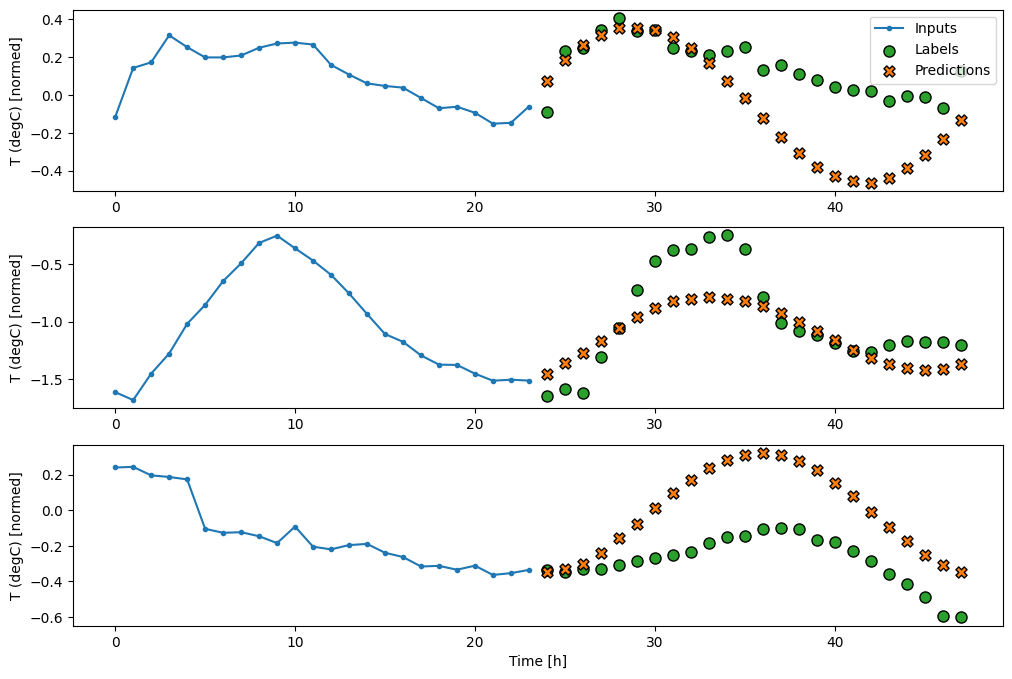

In [101]:
# Single-shot: single-step input multi-step output linear
history = compile_and_fit(multi_linear, multi_out)


multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear.evaluate(multi_out.val, return_dict=True)
multi_performance['Linear'] = multi_linear.evaluate(multi_out.test, verbose=0, return_dict=True)

for multiout_inputs, multiout_labels in multi_out.train.take(1):
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels
multi_out.plot(multi_linear)

437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2178 - mean_absolute_error: 0.2799


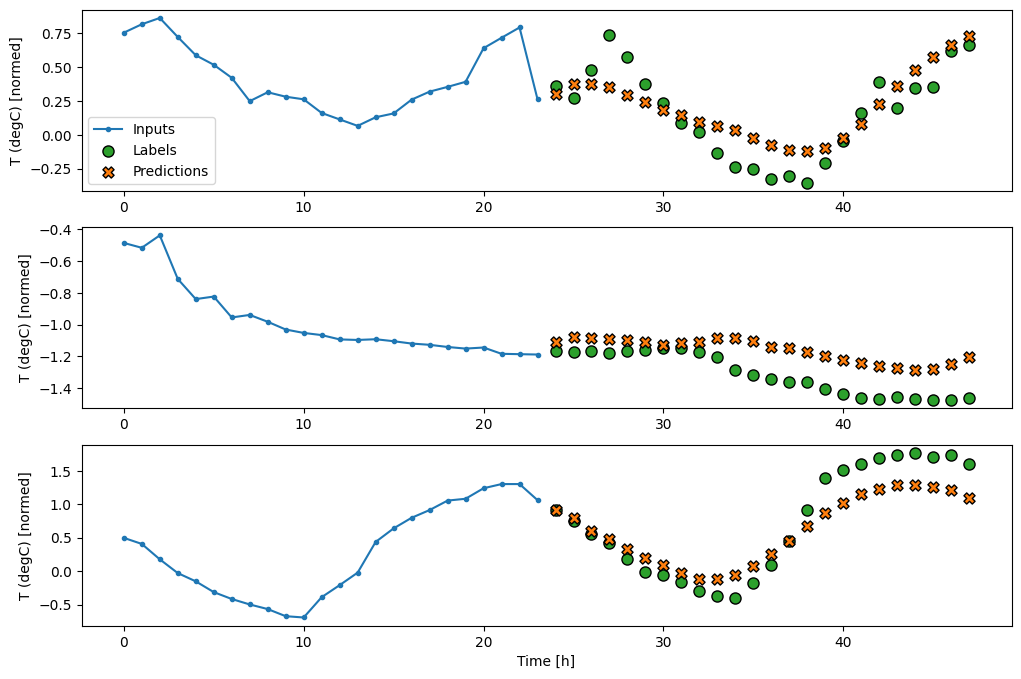

In [102]:
# Single-shot: single-step input multi-step output DNN
history = compile_and_fit(multi_output_dense, multi_out)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_output_dense.evaluate(multi_out.val, return_dict=True)
multi_performance['Dense'] = multi_output_dense.evaluate(multi_out.test, verbose=0, return_dict=True)

for multiout_inputs, multiout_labels in multi_out.train.take(1):
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels
multi_out.plot(multi_output_dense)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2116 - mean_absolute_error: 0.2800


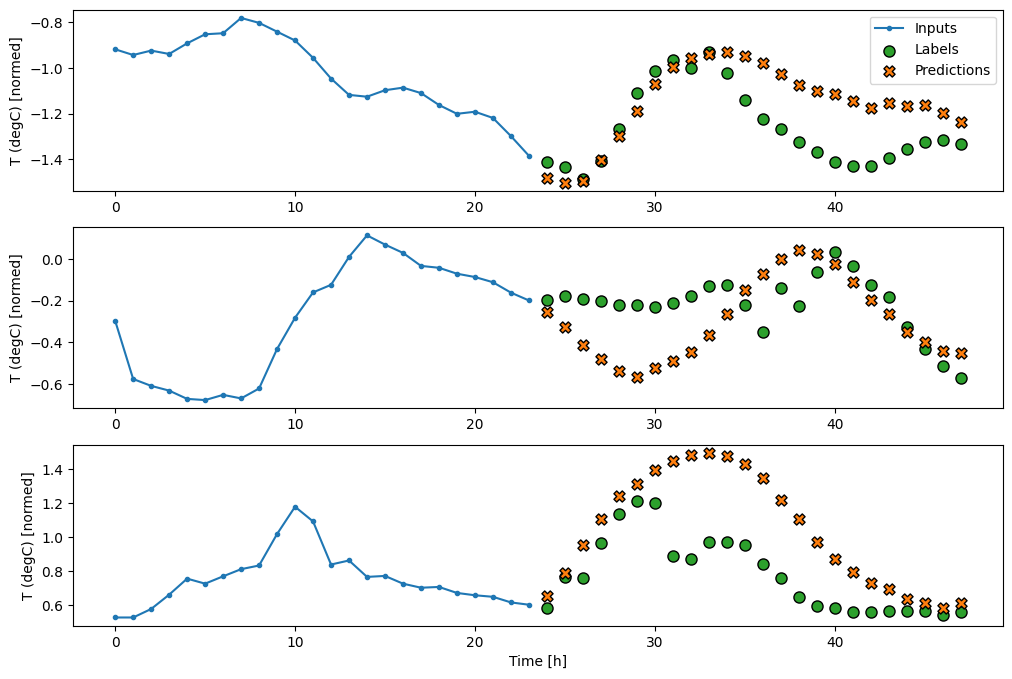

In [103]:
# Single-shot: multi-step output CNN
history = compile_and_fit(multi_cnn, multi_out)

IPython.display.clear_output()

multi_val_performance['CNN'] = multi_cnn.evaluate(multi_out.val, return_dict=True)
multi_performance['CNN'] = multi_cnn.evaluate(multi_out.test, verbose=0, return_dict=True)
for multiout_inputs, multiout_labels in multi_out.train.take(1):
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels
multi_out.plot(multi_cnn)

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2098 - mean_absolute_error: 0.2826


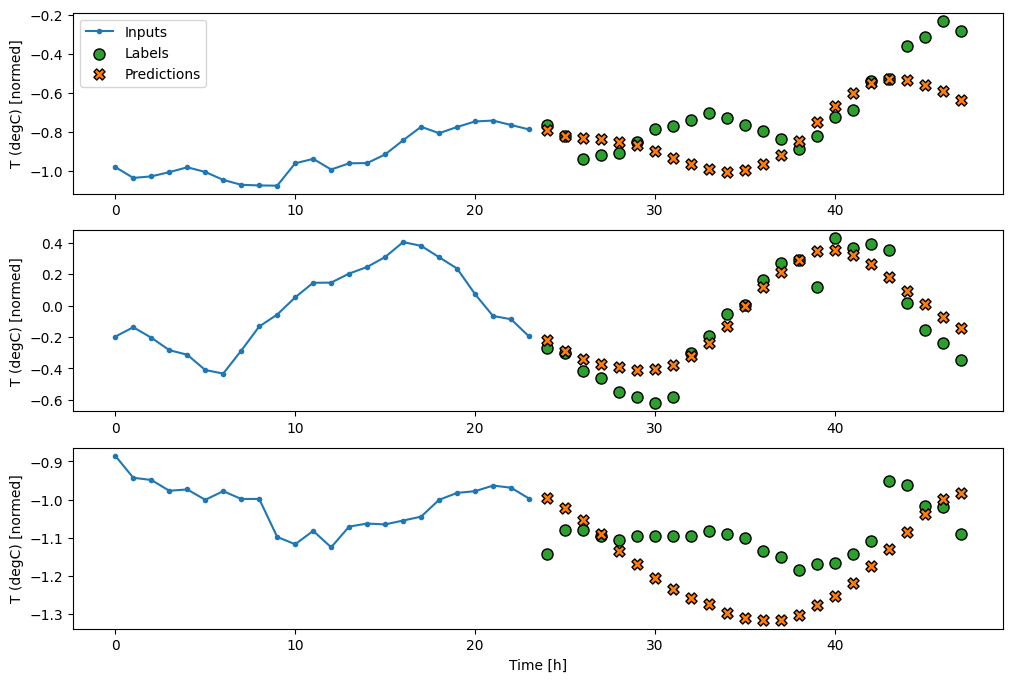

In [104]:
# Single-shot multi-step output RNN
history = compile_and_fit(multi_lstm, multi_out)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm.evaluate(multi_out.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm.evaluate(multi_out.test, verbose=0, return_dict=True)

for multiout_inputs, multiout_labels in multi_out.train.take(1):
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels
multi_out.plot(multi_lstm)

437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2212 - mean_absolute_error: 0.2984


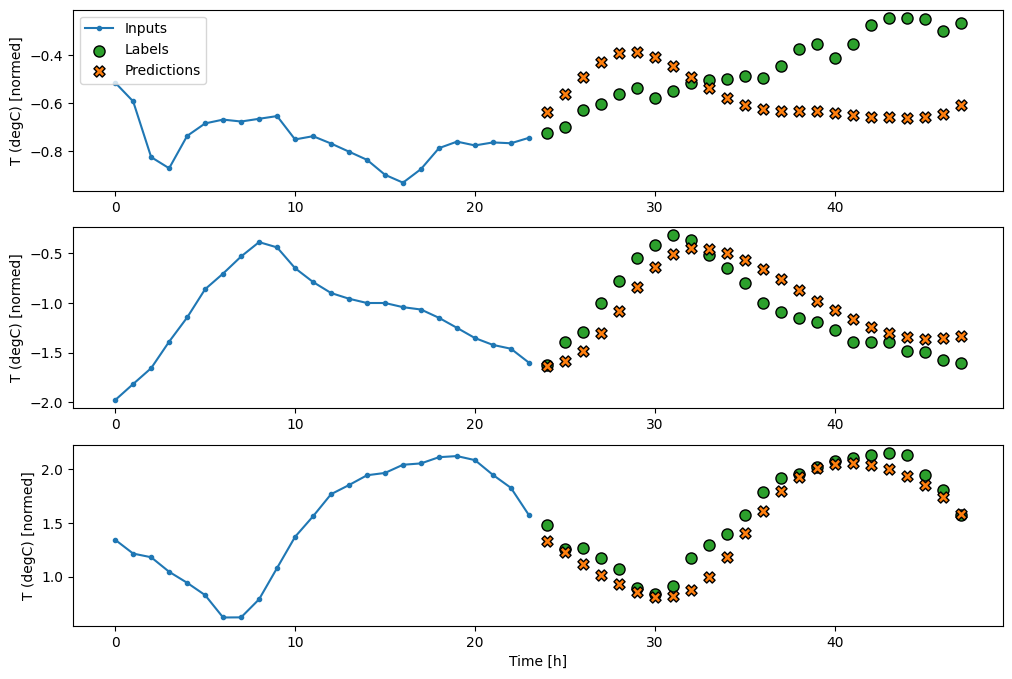

In [105]:
# Autoregressive RNN:LSTM
ar_rnn = autoregressive_rnn(units=32, out_steps=OUT_STEPS)
history = compile_and_fit(ar_rnn, multi_out)

IPython.display.clear_output()

multi_val_performance['Autoregressive LSTM'] = ar_rnn.evaluate(multi_out.val, return_dict=True)
multi_performance['Autoregressive LSTM'] = ar_rnn.evaluate(multi_out.test, verbose=0, return_dict=True)

for multiout_inputs, multiout_labels in multi_out.train.take(1):
  multi_out.inputs = multiout_inputs
  multi_out.labels = multiout_labels
multi_out.plot(ar_rnn)

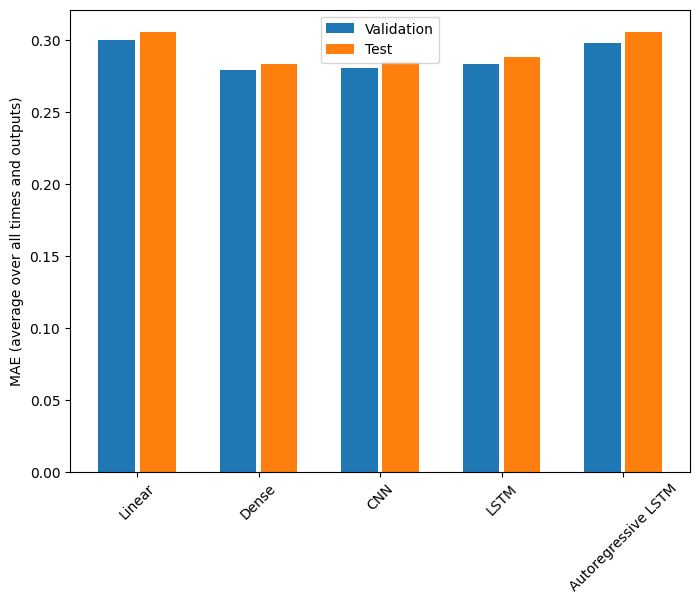

In [106]:
# Performance comparisons
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [107]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')

Linear  : 0.3053
Dense   : 0.2835
CNN     : 0.2845
LSTM    : 0.2881
Autoregressive LSTM: 0.3058
